In [1]:
#@title Import packages
import sys
import numpy as np
import scipy.io as sio
import time
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# Import wavefront code
import wf_psf as wf

import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
print('tf_version: ' + str(tf.__version__))


# Pre-defined colormap
top = mpl.cm.get_cmap('Oranges_r', 128)
bottom = mpl.cm.get_cmap('Blues', 128)
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
newcmp = ListedColormap(newcolors, name='OrangeBlue')



Found GPU at: /device:GPU:0
tf_version: 2.4.1


# Manage paths

In [2]:
# # Define saving paths
id_name = '_euclid_res_200stars_RecAdam_v2'

model = 'mccd'
# model = 'poly'
# model = 'param'

run_id_name = model + id_name
log_save_file = '/local/home/tliaudat/checkpoints/log-files/'
chkp_save_file = '/local/home/tliaudat/checkpoints/chkp/'
optim_hist_file = '/local/home/tliaudat/checkpoints/optim-hist/'
saving_optim_hist = dict()

# Input paths
Zcube_path = '/local/home/tliaudat/data/Zernike45.mat'
dataset_path = '/local/home/tliaudat/psf-datasets/'
train_path = 'train_Euclid_res_200_stars_dim256.npy'
test_path = 'test_Euclid_res_200_stars_dim256.npy'




## Model parameters

In [3]:
# Decimation factor for Zernike polynomials
decim_f = 4  # Original shape (1024x1024)
n_zernikes = 15

# Some parameters
pupil_diameter = 1024 // decim_f
n_bins_lda = 20

output_Q = 3.
oversampling_rate = 3.

batch_size = 16
output_dim = 32
d_max = 2
d_max_nonparam = 3  # polynomial-constraint features
x_lims = [0, 1e3]
y_lims = [0, 1e3]
graph_features = 10  # Graph-constraint features
l1_rate = 1e-8  # L1 regularisation


# Prepare inputs

In [4]:
# # Prepare the inputs
#title Input preparation

Zcube = sio.loadmat(Zcube_path)
zernikes = []
zernike_shape = int(1024/decim_f)


for it in range(n_zernikes):
    zernikes.append(wf.utils.downsample_im(Zcube['Zpols'][0,it][5], zernike_shape))

# Now as cubes
np_zernike_cube = np.zeros((len(zernikes), zernikes[0].shape[0], zernikes[0].shape[1]))

for it in range(len(zernikes)):
    np_zernike_cube[it,:,:] = zernikes[it]

np_zernike_cube[np.isnan(np_zernike_cube)] = 0

tf_zernike_cube = tf.convert_to_tensor(np_zernike_cube, dtype=tf.float32)

print('Zernike cube:')
print(tf_zernike_cube.shape)

del Zcube


Zernike cube:
(15, 256, 256)


In [5]:

# Load the dictionaries
train_dataset = np.load(dataset_path + train_path, allow_pickle=True)[()]
train_SEDs = train_dataset['SEDs']
train_C_poly = train_dataset['C_poly']
train_parameters = train_dataset['parameters']


test_dataset = np.load(dataset_path + test_path, allow_pickle=True)[()]
test_SEDs = test_dataset['SEDs']

# Convert to tensor
# tf_noisy_train_stars = tf.convert_to_tensor(train_dataset['noisy_stars'], dtype=tf.float32)
tf_train_stars = tf.convert_to_tensor(train_dataset['stars'], dtype=tf.float32)
tf_train_pos = tf.convert_to_tensor(train_dataset['positions'], dtype=tf.float32)

tf_test_stars = tf.convert_to_tensor(test_dataset['stars'], dtype=tf.float32)
tf_test_pos = tf.convert_to_tensor(test_dataset['positions'], dtype=tf.float32)

print('Dataset parameters:')
print(train_parameters)


Dataset parameters:
{'d_max': 2, 'max_order': 45, 'x_lims': [0, 1000.0], 'y_lims': [0, 1000.0], 'grid_points': [4, 4], 'n_bins': 20, 'max_wfe_rms': 0.1, 'oversampling_rate': 3.0, 'output_Q': 3.0, 'output_dim': 32, 'LP_filter_length': 2, 'pupil_diameter': 256, 'euclid_obsc': True, 'n_stars': 200, 'train_lim': 160}


# Generate model

In [6]:
# Generate initializations

# Prepare np input
simPSF_np = wf.SimPSFToolkit(zernikes, max_order=n_zernikes,
                                 pupil_diameter=pupil_diameter, output_dim=output_dim,
                                 oversampling_rate=oversampling_rate, output_Q=output_Q)
simPSF_np.gen_random_Z_coeffs(max_order=n_zernikes)
z_coeffs = simPSF_np.normalize_zernikes(simPSF_np.get_z_coeffs(), simPSF_np.max_wfe_rms)
simPSF_np.set_z_coeffs(z_coeffs)
simPSF_np.generate_mono_PSF(lambda_obs=0.7, regen_sample=False)

# Obscurations
obscurations = simPSF_np.generate_pupil_obscurations(N_pix=pupil_diameter, N_filter=2)
tf_obscurations = tf.convert_to_tensor(obscurations, dtype=tf.complex64)

# Initialize the SED data list
packed_SED_data = [wf.utils.generate_packed_elems(_sed, simPSF_np, n_bins=n_bins_lda)
                   for _sed in train_SEDs]


# Prepare the inputs for the training
tf_packed_SED_data = tf.convert_to_tensor(packed_SED_data, dtype=tf.float32)
tf_packed_SED_data = tf.transpose(tf_packed_SED_data, perm=[0, 2, 1])

inputs = [tf_train_pos, tf_packed_SED_data]

# Select the observed stars (noisy or noiseless)
# outputs = tf_noisy_train_stars
# outputs = tf_train_stars


In [7]:

# ## Select the model
if model == 'mccd':
    poly_dic, graph_dic = wf.tf_mccd_psf_field.build_mccd_spatial_dic_v2(obs_stars=train_dataset['noisy_stars'],
                                         obs_pos=tf_train_pos.numpy(),
                                         x_lims=x_lims,
                                         y_lims=y_lims,
                                         d_max=d_max_nonparam,
                                         graph_features=graph_features)

    spatial_dic = [poly_dic, graph_dic]

    # Initialize the model
    tf_semiparam_field = wf.tf_mccd_psf_field.TF_SP_MCCD_field(zernike_maps=tf_zernike_cube,
                                                                obscurations=tf_obscurations,
                                                                batch_size=batch_size,
                                                                obs_pos=tf_train_pos,
                                                                spatial_dic=spatial_dic,
                                                                output_Q=output_Q,
                                                                d_max_nonparam=d_max_nonparam,
                                                                graph_features=graph_features,
                                                                l1_rate=l1_rate,
                                                                output_dim=output_dim,
                                                                n_zernikes=n_zernikes,
                                                                d_max=d_max,
                                                                x_lims=x_lims,
                                                                y_lims=y_lims)

elif model == 'poly':
    # # Initialize the model
    tf_semiparam_field = wf.tf_psf_field.TF_SemiParam_field(zernike_maps=tf_zernike_cube,
                                            obscurations=tf_obscurations,
                                            batch_size=batch_size,
                                            output_Q=output_Q,
                                            d_max_nonparam=d_max_nonparam,
                                            output_dim=output_dim,
                                            n_zernikes=n_zernikes,
                                            d_max=d_max,
                                            x_lims=x_lims,
                                            y_lims=y_lims)

elif model == 'param':
    # Initialize the model
    tf_semiparam_field = wf.tf_psf_field.TF_PSF_field_model(zernike_maps=tf_zernike_cube,
                                            obscurations=tf_obscurations,
                                            batch_size=batch_size,
                                            output_dim=output_dim,
                                            n_zernikes=n_zernikes,
                                            d_max=d_max,
                                            x_lims=x_lims,
                                            y_lims=y_lims)




/local/home/tliaudat/.local/lib/python3.8/site-packages/wf_psf-0.0.1-py3.8.egg/wf_psf/graph_utils.py:107: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  self.VT = np.vstack((eigenvect for eigenvect in list_eigenvects))


# Prepare the GT model

In [8]:
# Preparate the GT model

Zcube = sio.loadmat(Zcube_path)
zernikes = []
# Decimation factor for Zernike polynomials
# decim_f = 4  # Original shape (1024x1024)
n_zernikes_bis = 45

for it in range(n_zernikes_bis):
    zernike_map = wf.utils.downsample_im(Zcube['Zpols'][0,it][5], 1024//decim_f)
    zernikes.append(zernike_map)

# Now as cubes
np_zernike_cube = np.zeros((len(zernikes), zernikes[0].shape[0], zernikes[0].shape[1]), dtype=np.float32)

for it in range(len(zernikes)):
    np_zernike_cube[it,:,:] = zernikes[it]

np_zernike_cube[np.isnan(np_zernike_cube)] = 0

tf_zernike_cube = tf.convert_to_tensor(np_zernike_cube, dtype=tf.float32)

# print('Zernike cube:')
# print(tf_zernike_cube.shape)

del Zcube, np_zernike_cube, zernikes

# Initialize the model
GT_tf_semiparam_field = wf.tf_psf_field.TF_SemiParam_field(
    zernike_maps=tf_zernike_cube,
    obscurations=tf_obscurations,
    batch_size=batch_size,
    output_Q=output_Q,
    d_max_nonparam=d_max_nonparam,
    output_dim=output_dim,
    n_zernikes=n_zernikes_bis,
    d_max=d_max,
    x_lims=x_lims,
    y_lims=y_lims)


# For the Ground truth model
GT_tf_semiparam_field.tf_poly_Z_field.assign_coeff_matrix(train_C_poly)
_ = GT_tf_semiparam_field.tf_np_poly_opd.alpha_mat.assign(np.zeros_like(GT_tf_semiparam_field.tf_np_poly_opd.alpha_mat))


# Plot training loss

In [9]:
# Save optimisation history dictionary
optim_hist = np.load(optim_hist_file + 'optim_hist_' + run_id_name + '.npy', allow_pickle=True)[()]


In [10]:

optim_hist.keys()

dict_keys(['param_cycle1', 'nonparam_cycle1', 'param_cycle2', 'nonparam_cycle2'])

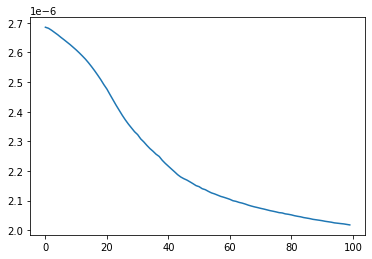

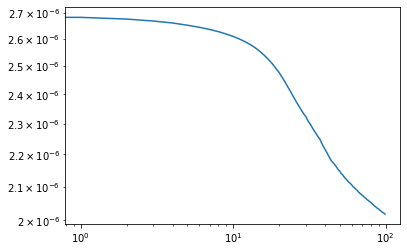

In [11]:
plt.figure()
plt.plot(optim_hist['nonparam_cycle1'])
plt.show()
plt.figure()
plt.loglog(optim_hist['nonparam_cycle1'])
plt.show()

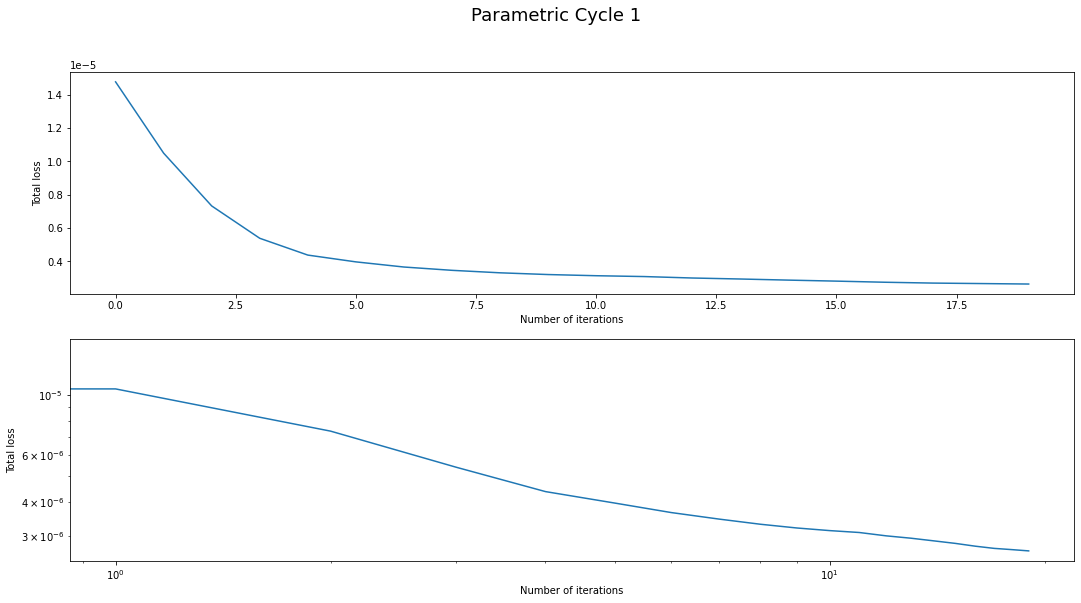

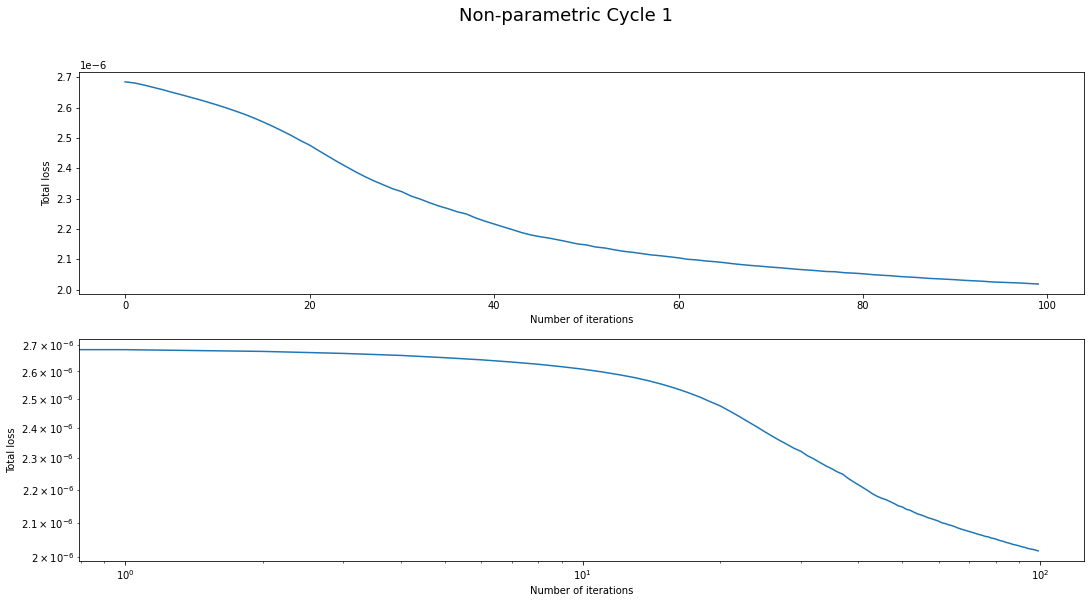

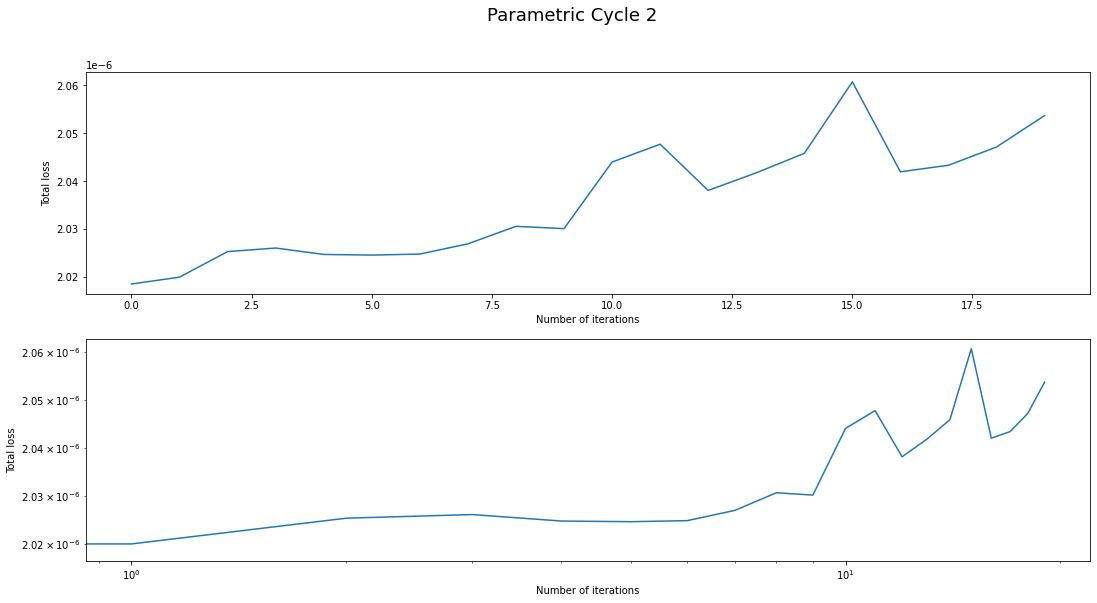

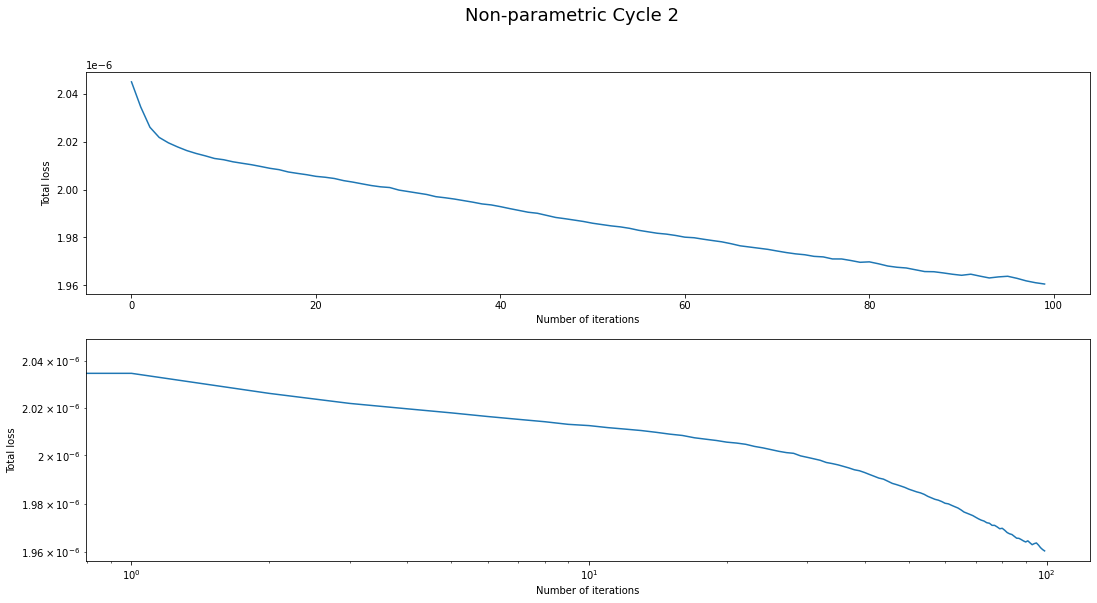

In [12]:

# Plot losses
plt.figure(figsize=(18,9))
plt.suptitle('Parametric Cycle 1', fontsize=18)
plt.subplot(211)
plt.plot(optim_hist['param_cycle1'])
plt.xlabel('Number of iterations')
plt.ylabel('Total loss');
plt.subplot(212)
plt.loglog(optim_hist['param_cycle1'])
plt.xlabel('Number of iterations')
plt.ylabel('Total loss');
plt.show()

# Plot losses
plt.figure(figsize=(18,9))
plt.suptitle('Non-parametric Cycle 1', fontsize=18)
plt.subplot(211)
plt.plot(optim_hist['nonparam_cycle1'])
plt.xlabel('Number of iterations')
plt.ylabel('Total loss');
plt.subplot(212)
plt.loglog(optim_hist['nonparam_cycle1'])
plt.xlabel('Number of iterations')
plt.ylabel('Total loss');
plt.show()


# Plot losses
plt.figure(figsize=(18,9))
plt.suptitle('Parametric Cycle 2', fontsize=18)
plt.subplot(211)
plt.plot(optim_hist['param_cycle2'])
plt.xlabel('Number of iterations')
plt.ylabel('Total loss');
plt.subplot(212)
plt.loglog(optim_hist['param_cycle2'])
plt.xlabel('Number of iterations')
plt.ylabel('Total loss');
plt.show()

# Plot losses
plt.figure(figsize=(18,9))
plt.suptitle('Non-parametric Cycle 2', fontsize=18)
plt.subplot(211)
plt.plot(optim_hist['nonparam_cycle2'])
plt.xlabel('Number of iterations')
plt.ylabel('Total loss');
plt.subplot(212)
plt.loglog(optim_hist['nonparam_cycle2'])
plt.xlabel('Number of iterations')
plt.ylabel('Total loss');
plt.show()


# Start evaluation

In [13]:
# Load the weights
tf_semiparam_field.load_weights(chkp_save_file + 'chkp_' + run_id_name + '_cycle2')


In [14]:
# # Set graph part to zero
# _ = tf_semiparam_field.tf_NP_mccd_OPD.alpha_graph.assign(tf.zeros_like(
#         tf_semiparam_field.tf_NP_mccd_OPD.alpha_graph, dtype=tf.float32))


In [15]:
# Compute the train/test pixel RMSE values
test_res, train_res = wf.metrics.compute_metrics(
     tf_semiparam_field, simPSF_np,
     test_SEDs=test_SEDs,
     train_SEDs=train_SEDs,
     tf_test_pos=tf_test_pos,
     tf_test_stars=tf_test_stars,
     tf_train_stars=tf_train_stars,
     tf_train_pos=tf_train_pos,
     n_bins_lda=n_bins_lda,
     batch_size=batch_size)

del tf_train_stars

Test stars absolute RMSE:	 2.4506e-04
Training stars absolute RMSE:	 2.1367e-04
Test stars relative RMSE:	 3.2137e+00 %
Training stars relative RMSE:	 2.6692e+00 %


In [16]:
# Compute the shape metrics
_, _ = wf.metrics.compute_shape_metrics(
    tf_semiparam_field,
    GT_tf_semiparam_field,
    simPSF_np,
    SEDs=train_SEDs,
    tf_pos=tf_train_pos,
    n_bins_lda=n_bins_lda,
    output_Q=1, output_dim=64, batch_size=16)




Pixel star absolute RMSE:	 7.6635e-05
Pixel star relative RMSE:	 4.7661e+00 %

sigma(e1) RMSE = 1.4585e-02
sigma(e2) RMSE = 6.4246e-03
sigma(R2)/<R2>  = 3.9596e-02 

relative sigma(e1) RMSE = 4.7429e+01 %
relative sigma(e2) RMSE = 2.8212e+01 %


In [17]:
# Compute the train/test OPD RMSE values
if model == 'mccd':
    train_opd_res, test_opd_res = wf.metrics.compute_opd_metrics(
        tf_semiparam_field, GT_tf_semiparam_field, tf_test_pos, tf_train_pos)

elif model == 'poly':
    train_opd_res, test_opd_res = wf.metrics.compute_opd_metrics_polymodel(
        tf_semiparam_field, GT_tf_semiparam_field, tf_test_pos, tf_train_pos)

elif model == 'param':
    train_opd_res, test_opd_res = wf.metrics.compute_opd_metrics_param_model(
        tf_semiparam_field, GT_tf_semiparam_field, tf_test_pos, tf_train_pos)

Test stars absolute OPD RMSE:	 9.5438e-02
Test stars relative OPD RMSE:	 1.3231e+02 %

Train stars absolute OPD RMSE:	 8.5327e-02
Test stars relative OPD RMSE:	 1.2988e+02 %



# Plots

## Plot learned matrices

Plot alpha


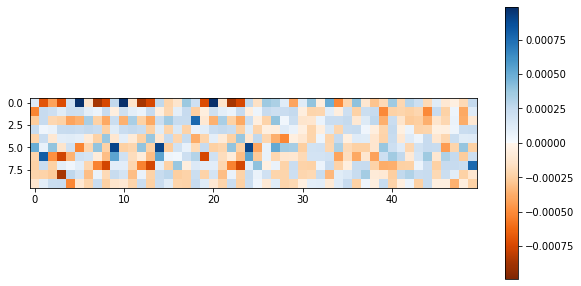

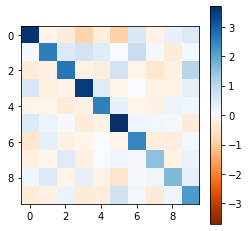

Plot A


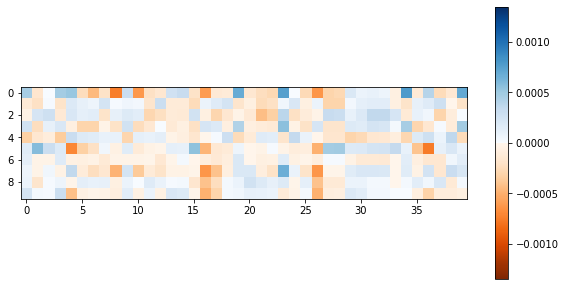

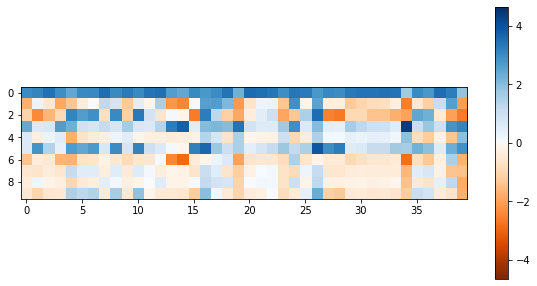

Plot S


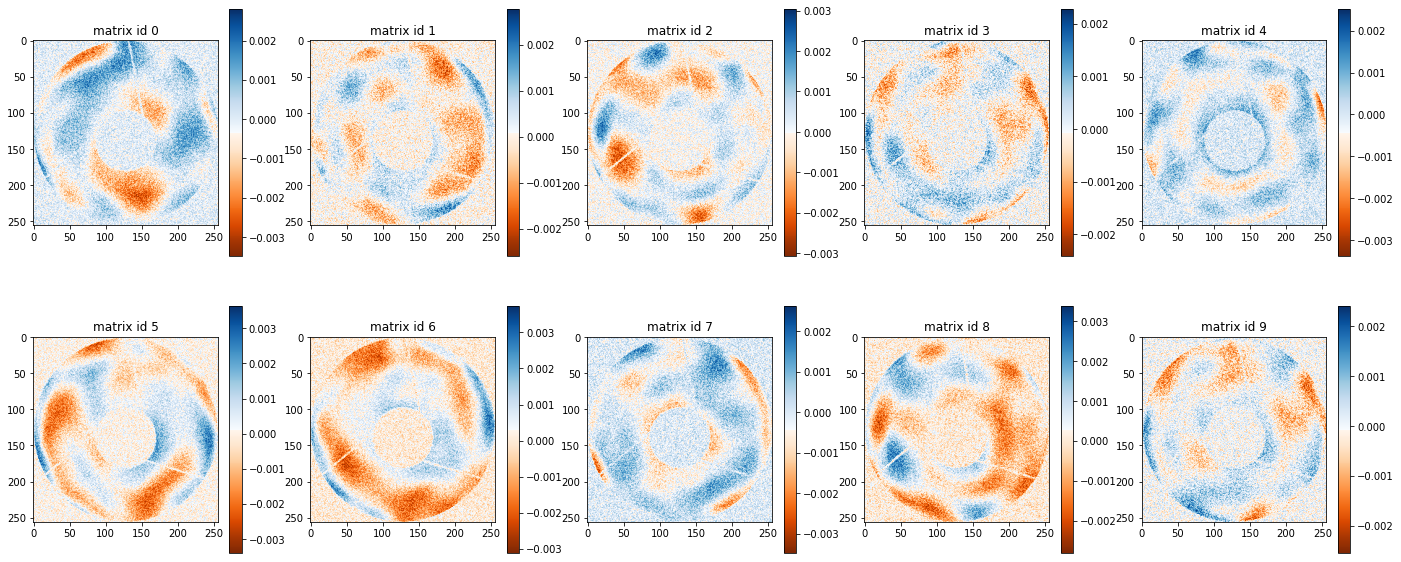

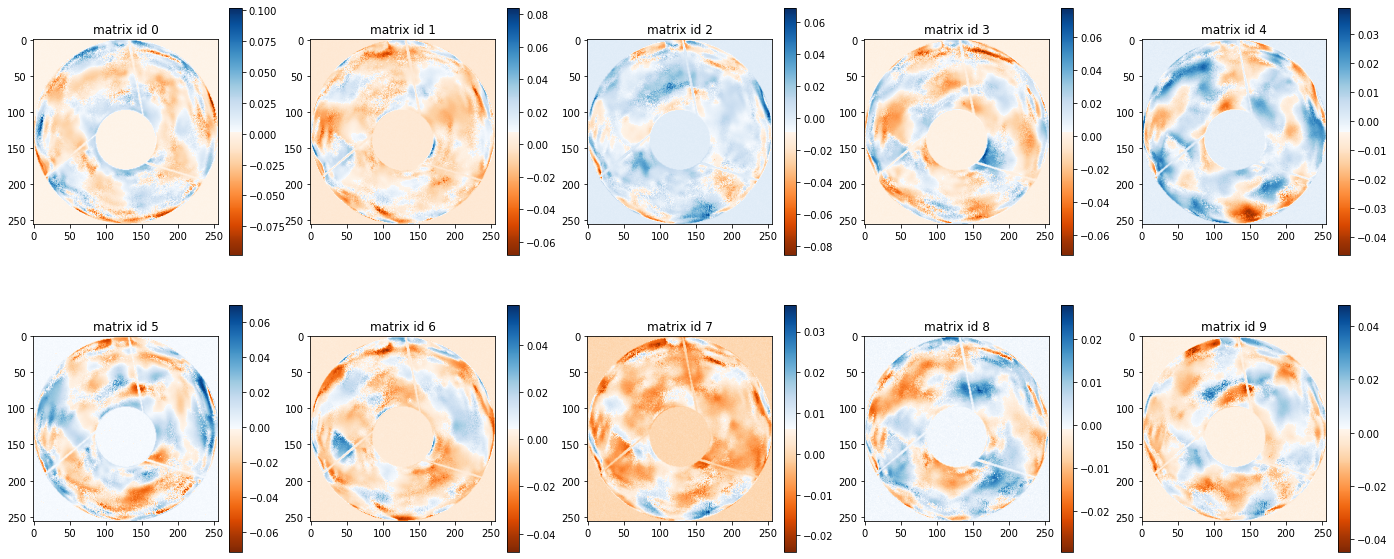

In [18]:
if model == 'poly':
    # Extract matrices
    alpha = tf_semiparam_field.tf_np_poly_opd.alpha_mat.numpy()
    S = tf_semiparam_field.tf_np_poly_opd.S_mat.numpy()

    # Plot
    plt.figure(figsize=(4,4))
    vmax = np.max(abs(alpha))
    plt.imshow(alpha.T, cmap=newcmp, vmax=vmax, vmin=-vmax);plt.colorbar()
    plt.show()

    wf.plot_imgs(S, cmap = newcmp, figsize=(24,10))

    
elif model == 'mccd':
    # Extract matrices
    alpha_graph = tf_semiparam_field.tf_NP_mccd_OPD.alpha_graph.numpy()
    alpha_poly = tf_semiparam_field.tf_NP_mccd_OPD.alpha_poly.numpy()
    S_poly = tf_semiparam_field.tf_NP_mccd_OPD.S_poly.numpy()
    S_graph = tf_semiparam_field.tf_NP_mccd_OPD.S_graph.numpy()

    A_graph = graph_dic.numpy()@alpha_graph
    A_poly = poly_dic.numpy()@alpha_poly
    
    # Plot alpha
    print('Plot alpha')
    plt.figure(figsize=(10,5))
    vmax = np.max(abs(alpha_graph))
    plt.imshow(alpha_graph.T, cmap=newcmp, vmax=vmax, vmin=-vmax);plt.colorbar()
    plt.show()

    plt.figure(figsize=(4,4))
    vmax = np.max(abs(alpha_poly))
    plt.imshow(alpha_poly.T, cmap=newcmp, vmax=vmax, vmin=-vmax);plt.colorbar()
    plt.show()
    
    # Plot A
    print('Plot A')
    plt.figure(figsize=(10,5))
    vmax = np.max(abs(A_graph))
    plt.imshow(A_graph[0:40,:].T, cmap=newcmp, vmax=vmax, vmin=-vmax);plt.colorbar()
    plt.show()

    plt.figure(figsize=(10,5))
    vmax = np.max(abs(A_poly))
    plt.imshow(A_poly[0:40,:].T, cmap=newcmp, vmax=vmax, vmin=-vmax);plt.colorbar()
    plt.show()
    
    # Plot S
    print('Plot S')
    wf.plot_imgs(S_graph, cmap = newcmp, figsize=(24,10))
    wf.plot_imgs(S_poly, cmap = newcmp, figsize=(24,10))
    
    

## Plot test star reconstrunctions

In [19]:
# Recover some PSF
star_id = 19

test_packed_SED_data = [wf.utils.generate_packed_elems(_sed, simPSF_np, n_bins=n_bins_lda)
                        for _sed in test_SEDs]

tf_test_packed_SED_data = tf.convert_to_tensor(test_packed_SED_data, dtype=tf.float32)
tf_test_packed_SED_data = tf.transpose(tf_test_packed_SED_data, perm=[0, 2, 1])
test_pred_inputs = [tf_test_pos[star_id:star_id+3,:] , tf_test_packed_SED_data[star_id:star_id+3,:]]
expected_outputs = tf_test_stars[star_id:star_id+3,:]

# Predict non-param test star
semiparam_pred = tf_semiparam_field.predict(x=test_pred_inputs, batch_size=batch_size)


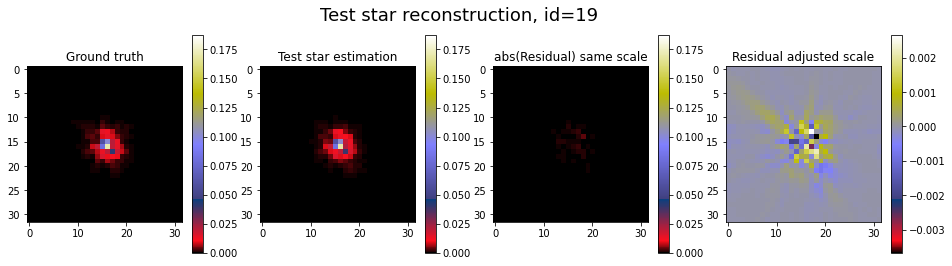

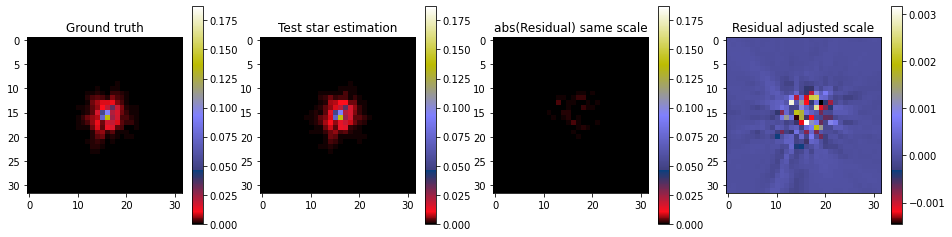

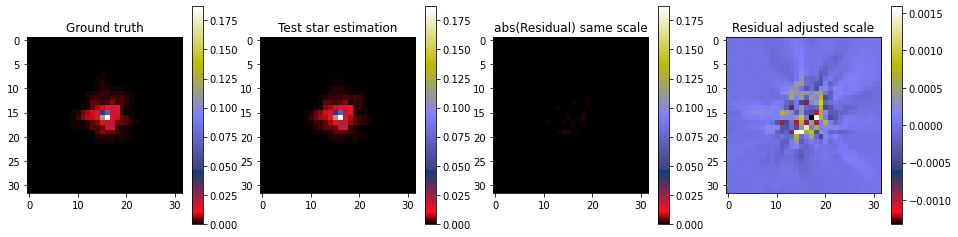

In [20]:

vmax = np.max(abs(expected_outputs))

plt.figure(figsize=(16,4))
plt.suptitle('Test star reconstruction, id=%d'%(star_id), fontsize=18)
plt.subplot(141)
plt.imshow(expected_outputs[0,:,:], cmap='gist_stern', vmax=vmax, vmin=0);plt.colorbar()
plt.title('Ground truth')
plt.subplot(142)
plt.imshow(semiparam_pred[0,:,:], cmap='gist_stern', vmax=vmax, vmin=0);plt.colorbar()
plt.title('Test star estimation')
plt.subplot(143)
plt.imshow(abs(expected_outputs[0,:,:] - semiparam_pred[0,:,:]), cmap='gist_stern', vmax=vmax, vmin=0);plt.colorbar()
plt.title('abs(Residual) same scale')
plt.subplot(144)
plt.imshow(expected_outputs[0,:,:] - semiparam_pred[0,:,:], cmap='gist_stern');plt.colorbar()
plt.title('Residual adjusted scale')
plt.show()

plt.figure(figsize=(16,4))
plt.subplot(141)
plt.imshow(expected_outputs[1,:,:], cmap='gist_stern', vmax=vmax, vmin=0);plt.colorbar()
plt.title('Ground truth')
plt.subplot(142)
plt.imshow(semiparam_pred[1,:,:], cmap='gist_stern', vmax=vmax, vmin=0);plt.colorbar()
plt.title('Test star estimation')
plt.subplot(143)
plt.imshow(abs(expected_outputs[1,:,:] - semiparam_pred[1,:,:]), cmap='gist_stern', vmax=vmax, vmin=0);plt.colorbar()
plt.title('abs(Residual) same scale')
plt.subplot(144)
plt.imshow(expected_outputs[1,:,:] - semiparam_pred[1,:,:], cmap='gist_stern');plt.colorbar()
plt.title('Residual adjusted scale')
plt.show()

plt.figure(figsize=(16,4))
plt.subplot(141)
plt.imshow(expected_outputs[2,:,:], cmap='gist_stern', vmax=vmax, vmin=0);plt.colorbar()
plt.title('Ground truth')
plt.subplot(142)
plt.imshow(semiparam_pred[2,:,:], cmap='gist_stern', vmax=vmax, vmin=0);plt.colorbar()
plt.title('Test star estimation')
plt.subplot(143)
plt.imshow(abs(expected_outputs[2,:,:] - semiparam_pred[2,:,:]), cmap='gist_stern', vmax=vmax, vmin=0);plt.colorbar()
plt.title('abs(Residual) same scale')
plt.subplot(144)
plt.imshow(expected_outputs[2,:,:] - semiparam_pred[2,:,:], cmap='gist_stern');plt.colorbar()
plt.title('Residual adjusted scale')
plt.show()



## Plot OPD errors

In [21]:
# For the trained model

if model == 'mccd':
    is_poly = False
elif model == 'poly':
    is_poly = True

# Unpack inputs
input_positions = test_pred_inputs[0]
packed_SEDs = test_pred_inputs[1]

# Forward semi-param model Z15
# Calculate parametric part
SP_zernike_coeffs = tf_semiparam_field.tf_poly_Z_field(input_positions)
param_opd_maps = tf_semiparam_field.tf_zernike_OPD(SP_zernike_coeffs)

# Calculate the non parametric part
if is_poly == False:
    nonparam_opd_maps =  tf_semiparam_field.tf_NP_mccd_OPD.predict(input_positions)
else:
    nonparam_opd_maps =  tf_semiparam_field.tf_np_poly_opd(input_positions)
    
# Add the estimations
opd_maps = tf.math.add(param_opd_maps, nonparam_opd_maps)

full_poly_psfs = tf_semiparam_field.tf_batch_poly_PSF([opd_maps, packed_SEDs])

NP_poly_psfs = tf_semiparam_field.tf_batch_poly_PSF([nonparam_opd_maps, packed_SEDs])
P_poly_psfs = tf_semiparam_field.tf_batch_poly_PSF([param_opd_maps, packed_SEDs])


# Forward param model Z45
GT_zernike_coeffs = GT_tf_semiparam_field.tf_poly_Z_field(input_positions)
GT_opd_maps = GT_tf_semiparam_field.tf_zernike_OPD(GT_zernike_coeffs)
GT_poly_psfs = GT_tf_semiparam_field.tf_batch_poly_PSF([GT_opd_maps, packed_SEDs])



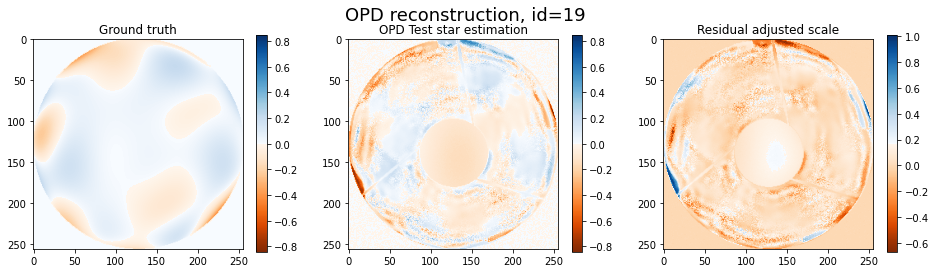

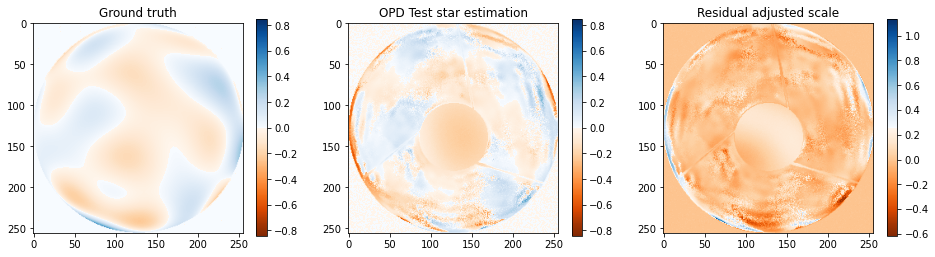

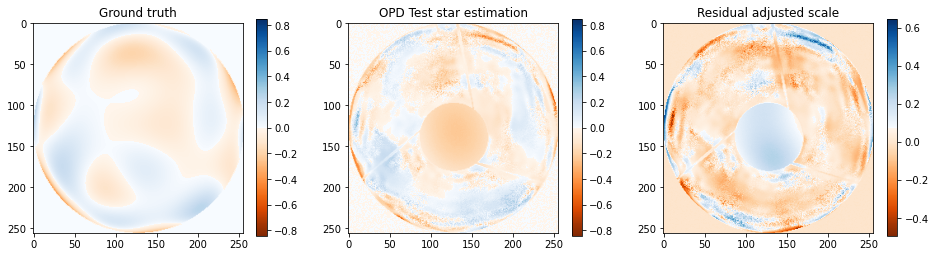

In [22]:

vmax = np.max([np.max(abs(GT_opd_maps)), np.max(abs(opd_maps))])
chosen_cmap = newcmp

plt.figure(figsize=(16,4))
plt.suptitle('OPD reconstruction, id=%d'%(star_id), fontsize=18)
plt.subplot(131)
plt.imshow(GT_opd_maps[0,:,:], cmap=chosen_cmap, vmax=vmax, vmin=-vmax);plt.colorbar()
plt.title('Ground truth')
plt.subplot(132)
plt.imshow(opd_maps[0,:,:], cmap=chosen_cmap, vmax=vmax, vmin=-vmax);plt.colorbar()
plt.title('OPD Test star estimation')
plt.subplot(133)
plt.imshow(GT_opd_maps[0,:,:] - opd_maps[0,:,:], cmap=chosen_cmap);plt.colorbar()
plt.title('Residual adjusted scale')
plt.show()

plt.figure(figsize=(16,4))
plt.subplot(131)
plt.imshow(GT_opd_maps[1,:,:], cmap=chosen_cmap, vmax=vmax, vmin=-vmax);plt.colorbar()
plt.title('Ground truth')
plt.subplot(132)
plt.imshow(opd_maps[1,:,:], cmap=chosen_cmap, vmax=vmax, vmin=-vmax);plt.colorbar()
plt.title('OPD Test star estimation')
plt.subplot(133)
plt.imshow(GT_opd_maps[1,:,:] - opd_maps[1,:,:], cmap=chosen_cmap);plt.colorbar()
plt.title('Residual adjusted scale')
plt.show()

plt.figure(figsize=(16,4))
plt.subplot(131)
plt.imshow(GT_opd_maps[2,:,:], cmap=chosen_cmap, vmax=vmax, vmin=-vmax);plt.colorbar()
plt.title('Ground truth')
plt.subplot(132)
plt.imshow(opd_maps[2,:,:], cmap=chosen_cmap, vmax=vmax, vmin=-vmax);plt.colorbar()
plt.title('OPD Test star estimation')
plt.subplot(133)
plt.imshow(GT_opd_maps[2,:,:] - opd_maps[2,:,:], cmap=chosen_cmap);plt.colorbar()
plt.title('Residual adjusted scale')
plt.show()


## Plot error maps

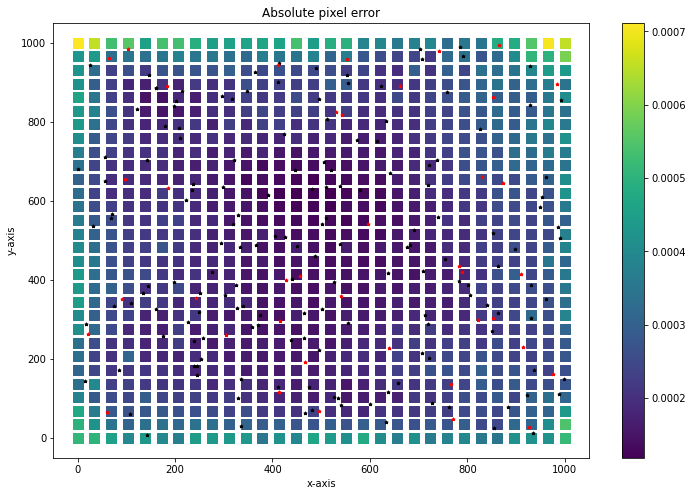

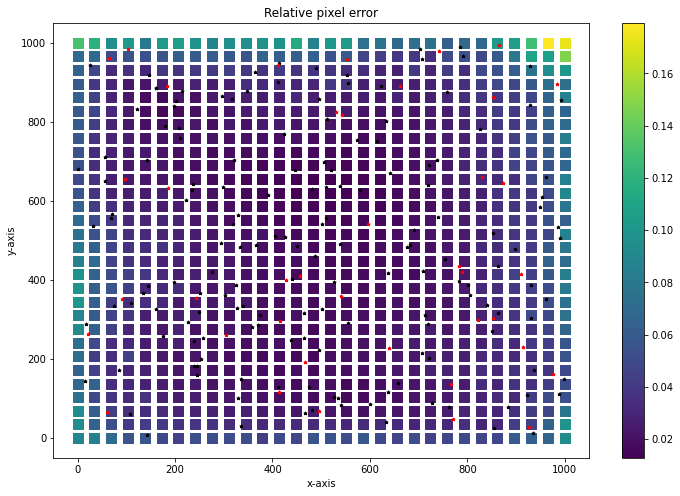

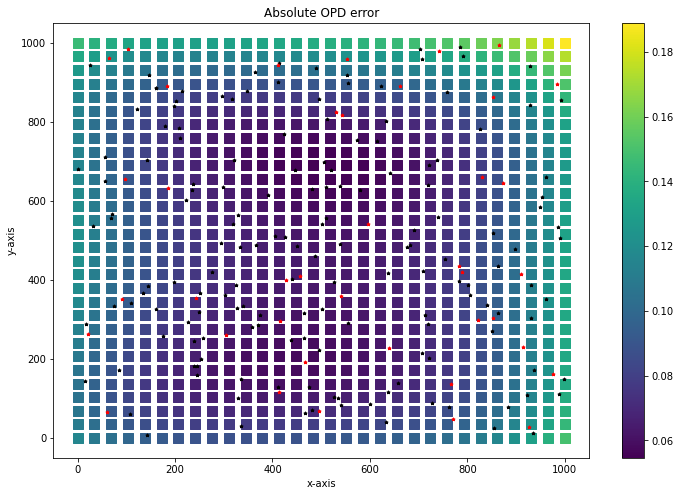

In [23]:
wf.metrics.plot_residual_maps(GT_tf_semiparam_field, tf_semiparam_field, simPSF_np,
                   train_SEDs, tf_train_pos, tf_test_pos, n_bins_lda=n_bins_lda,
                   n_points_per_dim=30, is_poly=is_poly)


## Incomplete PSF estimations

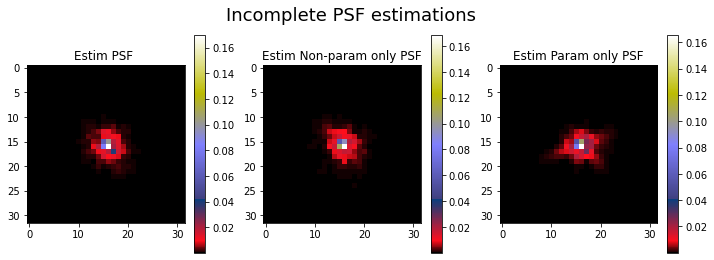

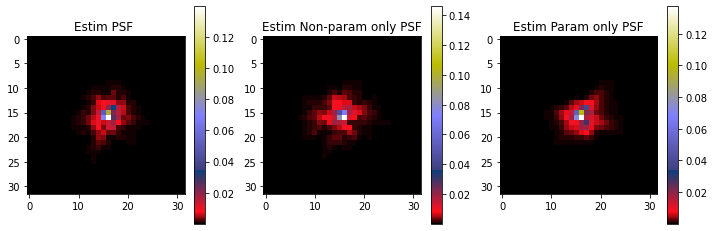

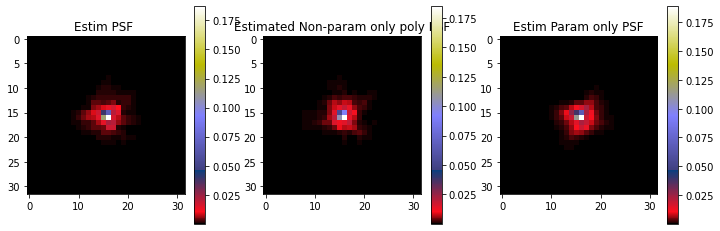

In [24]:
ex_id = 0
plt.figure(figsize=(12,4))
plt.suptitle('Incomplete PSF estimations', fontsize=18)
plt.subplot(131)
plt.imshow(full_poly_psfs[ex_id,:,:], cmap='gist_stern');plt.colorbar()
plt.title('Estim PSF ')
plt.subplot(132)
plt.imshow(NP_poly_psfs[ex_id,:,:], cmap='gist_stern');plt.colorbar()
plt.title('Estim Non-param only PSF')
plt.subplot(133)
plt.imshow(P_poly_psfs[ex_id,:,:], cmap='gist_stern');plt.colorbar()
plt.title('Estim Param only PSF')
plt.show()


ex_id = 1
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(full_poly_psfs[ex_id,:,:], cmap='gist_stern');plt.colorbar()
plt.title('Estim PSF ')
plt.subplot(132)
plt.imshow(NP_poly_psfs[ex_id,:,:], cmap='gist_stern');plt.colorbar()
plt.title('Estim Non-param only PSF')
plt.subplot(133)
plt.imshow(P_poly_psfs[ex_id,:,:], cmap='gist_stern');plt.colorbar()
plt.title('Estim Param only PSF')
plt.show()


ex_id = 2
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(full_poly_psfs[ex_id,:,:], cmap='gist_stern');plt.colorbar()
plt.title('Estim PSF ')
plt.subplot(132)
plt.imshow(NP_poly_psfs[ex_id,:,:], cmap='gist_stern');plt.colorbar()
plt.title('Estimated Non-param only poly PSF') 
plt.subplot(133)
plt.imshow(P_poly_psfs[ex_id,:,:], cmap='gist_stern');plt.colorbar()
plt.title('Estim Param only PSF')
plt.show()

